### Kaggle Link: [Click here](https://www.kaggle.com/code/nyinyeinaung/xgbclassifier-with-parameter-tuning-classification)
Competition Link: [Click here](https://www.kaggle.com/competitions/playground-series-s3e23)

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import cv
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report,accuracy_score,ConfusionMatrixDisplay,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline


import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

# Import Data

In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s3e23/train.csv')
df.head(5)

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [3]:
#view data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 101763 non-null  int64  
 1   loc                101763 non-null  float64
 2   v(g)               101763 non-null  float64
 3   ev(g)              101763 non-null  float64
 4   iv(g)              101763 non-null  float64
 5   n                  101763 non-null  float64
 6   v                  101763 non-null  float64
 7   l                  101763 non-null  float64
 8   d                  101763 non-null  float64
 9   i                  101763 non-null  float64
 10  e                  101763 non-null  float64
 11  b                  101763 non-null  float64
 12  t                  101763 non-null  float64
 13  lOCode             101763 non-null  int64  
 14  lOComment          101763 non-null  int64  
 15  lOBlank            101763 non-null  int64  
 16  lo

In [4]:
#check for duplicates
df.duplicated().sum()

0

In [5]:
#check for nulls
df.isna().sum()

id                   0
loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64

Text(0.5, 1.0, 'Features Correlation')

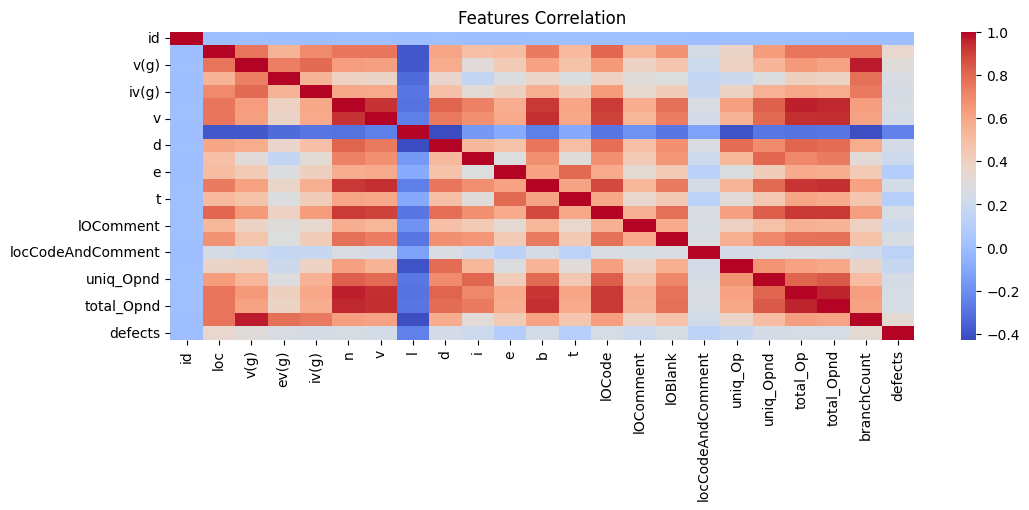

In [6]:
df_corr=df.corr()
sns.heatmap(df_corr,cmap='coolwarm')
plt.title('Features Correlation')

# Split Data 

In [53]:
X = df.drop(['id','defects'],axis=1)
y = df['defects'].apply(int)
feature_names = list(X.columns)
ID = 'id'
target='defects'


data_dmatrix = xgb.DMatrix(data=X,label=y,feature_names=feature_names)

X_train,X_valid, y_train,y_valid = train_test_split(X,y,stratify=y,test_size=0.3, random_state=1)
X_train.shape,X_valid.shape,y_train.shape,y_valid.shape

((71234, 21), (30529, 21), (71234,), (30529,))

# Finding XGB classifier with hyperparameter-tuning

In [19]:
train = df
print(train.shape)

target = 'defects'
IDcol = 'id'

(101763, 23)


In [20]:
train['defects'].value_counts()

defects
False    78699
True     23064
Name: count, dtype: int64

# Reusable function for model creation, training and evaluation

In [39]:
def modelfit(model, dtrain,predictors,useTrainCV=True,cv_folds=5,early_stopping_rounds = 50):
    
    #run CV
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        model.set_params(n_estimators=cvresult.shape[0])
        
    #fit the model on the data
    model.fit(dtrain[predictors],dtrain['defects'])
    
    #predict on training set
    dtrain_predictions = model.predict(dtrain[predictors])
    dtrain_predprob = model.predict_proba(dtrain[predictors])[:,1]
    
    #Print model report for training data
    print("\nModel Report")
    print(f"Accuracy : {metrics.accuracy_score(dtrain['defects'].values,dtrain_predictions):.4f}")
    print(f"AUC Score (Train): {metrics.roc_auc_score(dtrain['defects'], dtrain_predprob):.1f}")
    
        
    
    #feature importance
    feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    
    

## Baseline Model


 Model Report
Accuracy : 0.8192
AUC Score (Train): 0.8


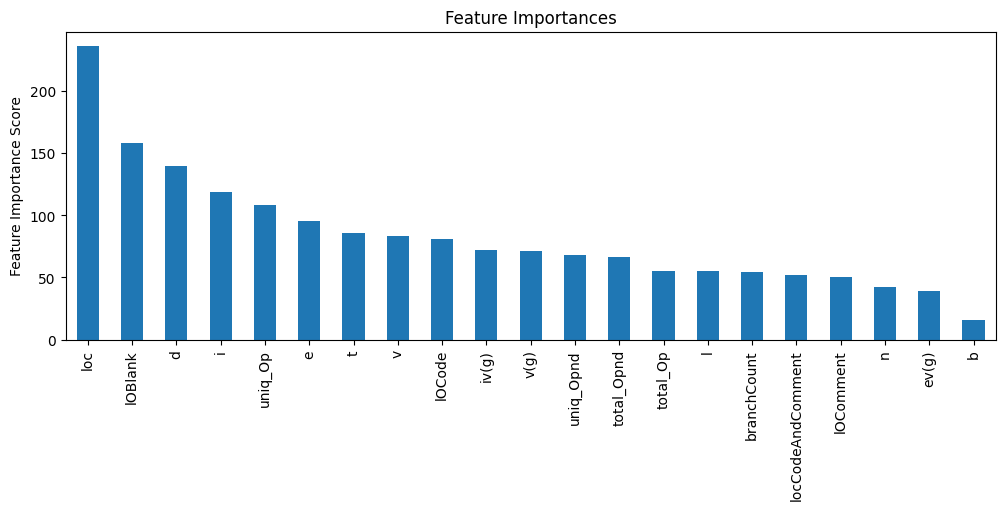

In [22]:
predictors = [x for x in train.columns if x not in [target,IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        eval_metric='auc',
        seed=27)
modelfit(xgb1, train, predictors)

## Finding the best parameters

In [23]:
#grid search with max_depth and min_child_weight
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1,n_estimators=140,max_depth=5,
                                                 min_child_weight = 1, gamma=0,subsample=0.8,colsample_bytree=0.8,
                                                 objective = 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27,eval_metric='auc'),
                        param_grid = param_test1,scoring='roc_auc',n_jobs=4,cv=3)
gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=0, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='roc_auc')

In [25]:
gs1Results = pd.DataFrame(gsearch1.cv_results_)
gs1Results,gsearch1.best_params_,gsearch1.best_score_

(    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
 0       68.224278      1.603837         0.170938        0.018139   
 1       66.018907      0.997868         0.174168        0.005655   
 2       65.136237      0.251609         0.225364        0.027274   
 3      140.290062      0.338098         0.261276        0.014635   
 4      129.309411      1.403782         0.252820        0.008744   
 5      125.639308      1.682151         0.235254        0.008192   
 6      236.099566      0.534346         0.326139        0.008530   
 7      212.734183      4.294739         0.318204        0.010150   
 8      207.025388      2.650195         0.302490        0.011646   
 9      341.642590      5.900286         0.407483        0.014435   
 10     313.695359      2.078848         0.444067        0.023531   
 11     222.051300     73.223385         0.210295        0.082641   
 
    param_max_depth param_min_child_weight  \
 0                3                      1   
 1       

In [29]:
gs1Results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,68.224278,1.603837,0.170938,0.018139,3,1,"{'max_depth': 3, 'min_child_weight': 1}",0.790133,0.793140,0.790241,0.791171,0.001393,3
1,66.018907,0.997868,0.174168,0.005655,3,3,"{'max_depth': 3, 'min_child_weight': 3}",0.790073,0.793269,0.790237,0.791193,0.001470,2
2,65.136237,0.251609,0.225364,0.027274,3,5,"{'max_depth': 3, 'min_child_weight': 5}",0.790242,0.793138,0.790468,0.791283,0.001315,1
3,140.290062,0.338098,0.261276,0.014635,5,1,"{'max_depth': 5, 'min_child_weight': 1}",0.789023,0.793294,0.789012,0.790443,0.002016,6
4,129.309411,1.403782,0.252820,0.008744,5,3,"{'max_depth': 5, 'min_child_weight': 3}",0.789162,0.793080,0.789528,0.790590,0.001767,5
5,125.639308,1.682151,0.235254,0.008192,5,5,"{'max_depth': 5, 'min_child_weight': 5}",0.789257,0.793592,0.789292,0.790714,0.002036,4
6,236.099566,0.534346,0.326139,0.008530,7,1,"{'max_depth': 7, 'min_child_weight': 1}",0.786324,0.790319,0.787244,0.787963,0.001708,9
7,212.734183,4.294739,0.318204,0.010150,7,3,"{'max_depth': 7, 'min_child_weight': 3}",0.786726,0.790811,0.787438,0.788325,0.001782,8
8,207.025388,2.650195,0.302490,0.011646,7,5,"{'max_depth': 7, 'min_child_weight': 5}",0.787268,0.791275,0.788141,0.788895,0.001721,7
9,341.642590,5.900286,0.407483,0.014435,9,1,"{'max_depth': 9, 'min_child_weight': 1}",0.781545,0.785343,0.782140,0.783009,0.001668,12


In [26]:
#Grid search with specified values for max_depth and min_child_weight
param_test2 = {
    'max_depth' :[4,5,6],
    'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1,n_estimators=140,max_depth = 5,
                                                 min_child_weight = 2, gamma = 0, subsample = 0.8,colsample_bytree = 0.8,
                                                 objective='binary:logistic',nthread=4,scale_pos_weight = 1, seed=27,eval_metric='auc'),
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,cv=3)
gsearch2.fit(train[predictors],train[target])


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=0, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4,
             param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [4, 5, 6]},
             scoring='roc_auc')

In [35]:
gs2Results = pd.DataFrame(gsearch2.cv_results_)
print(gsearch2.best_params_,gsearch2.best_score_)
gs2Results
# best max_depth is 4, min_child_weight is also 4

{'max_depth': 4, 'min_child_weight': 4} 0.7913522169500017


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,94.555769,0.520407,0.204693,0.011649,4,4,"{'max_depth': 4, 'min_child_weight': 4}",0.790046,0.793361,0.790650,0.791352,0.001442,1
1,94.037081,1.986006,0.209895,0.010688,4,5,"{'max_depth': 4, 'min_child_weight': 5}",0.789877,0.793406,0.789861,0.791048,0.001667,3
2,93.994911,0.887464,0.208355,0.011139,4,6,"{'max_depth': 4, 'min_child_weight': 6}",0.789915,0.793174,0.790320,0.791136,0.001450,2
3,127.722838,0.863616,0.249577,0.004755,5,4,"{'max_depth': 5, 'min_child_weight': 4}",0.789524,0.793004,0.789288,0.790605,0.001699,6
4,128.787251,2.207160,0.241016,0.018455,5,5,"{'max_depth': 5, 'min_child_weight': 5}",0.789257,0.793592,0.789292,0.790714,0.002036,5
5,125.619891,0.902135,0.247698,0.008949,5,6,"{'max_depth': 5, 'min_child_weight': 6}",0.789448,0.793226,0.789653,0.790776,0.001734,4
6,167.536592,1.093040,0.282476,0.015255,6,4,"{'max_depth': 6, 'min_child_weight': 4}",0.788431,0.791784,0.788955,0.789723,0.001473,9
7,166.393803,1.911079,0.285281,0.007323,6,5,"{'max_depth': 6, 'min_child_weight': 5}",0.788717,0.791932,0.788621,0.789757,0.001539,8
8,132.253475,23.626404,0.149922,0.059901,6,6,"{'max_depth': 6, 'min_child_weight': 6}",0.788626,0.791842,0.789153,0.789874,0.001408,7


In [36]:
#test on gamma
param_test3={
    'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1,n_estimators=140,max_depth = 4,
                                                 min_child_weight = 4, gamma = 0, subsample = 0.8,colsample_bytree = 0.8,
                                                 objective='binary:logistic',nthread=4,scale_pos_weight = 1, seed=27,eval_metric='auc'),
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,cv=3)
gsearch3.fit(train[predictors],train[target])

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=0, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=4,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4, param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             scoring='roc_auc')

In [37]:
gs3_results = pd.DataFrame(gsearch3.cv_results_)
print(gsearch3.best_params_,gsearch3.best_score_)
gs3_results
#Best gamma is 0

{'gamma': 0.0} 0.7913522169500017


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,92.144440,1.039602,0.200756,0.018537,0.0,{'gamma': 0.0},0.790046,0.793361,0.790650,0.791352,0.001442,1
1,94.422433,0.471381,0.207187,0.010636,0.1,{'gamma': 0.1},0.789982,0.793361,0.790641,0.791328,0.001463,2
2,94.996384,1.739485,0.196394,0.020892,0.2,{'gamma': 0.2},0.790027,0.793361,0.790491,0.791293,0.001475,3
3,94.124487,1.572225,0.220083,0.010859,0.3,{'gamma': 0.3},0.789985,0.793366,0.790494,0.791282,0.001488,4
4,81.631135,1.509063,0.115410,0.056721,0.4,{'gamma': 0.4},0.789983,0.793310,0.790361,0.791218,0.001487,5



 Model Report
Accuracy : 0.8179
AUC Score (Train): 0.8


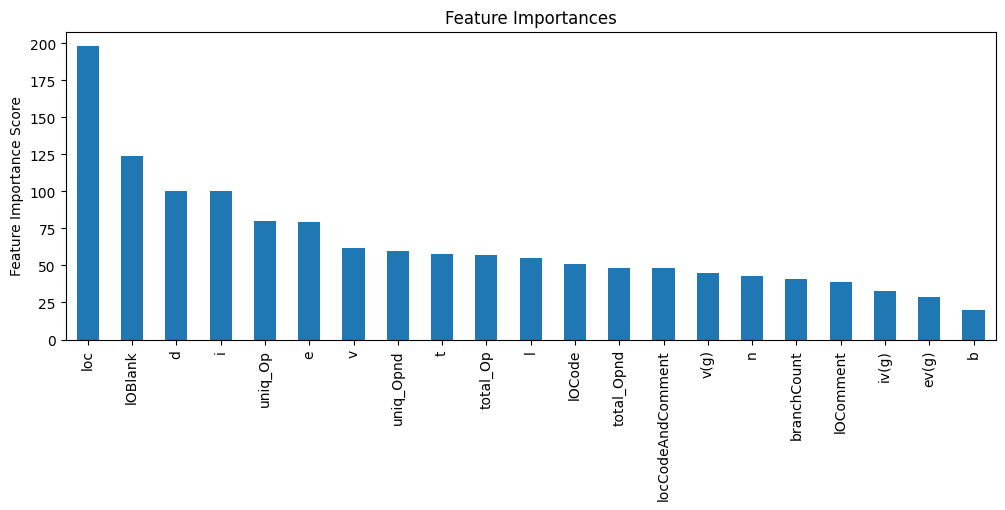

In [38]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=4,
        min_child_weight=4,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        eval_metric='auc',
        seed=27)
modelfit(xgb2, train, predictors)

In [40]:
#tune colsample_bytree and subsample
param_test4={
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}


gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1,n_estimators=140,max_depth = 4,
                                                 min_child_weight = 4, gamma = 0, subsample = 0.8,colsample_bytree = 0.8,
                                                 objective='binary:logistic',nthread=4,scale_pos_weight = 1, seed=27,eval_metric='auc'),
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,cv=3)
gsearch4.fit(train[predictors],train[target])

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=0, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=4,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             scoring='roc_auc')

In [41]:
gs4_results = pd.DataFrame(gsearch4.cv_results_)
print(gsearch4.best_params_,gsearch4.best_score_)
gs4_results
#best subsample is 0.6, best colsample_bytree is 0.9

{'colsample_bytree': 0.9, 'subsample': 0.6} 0.7914706277116731


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,91.956433,1.992072,0.300537,0.044137,0.6,0.6,"{'colsample_bytree': 0.6, 'subsample': 0.6}",0.790729,0.793591,0.790034,0.791452,0.001539,2
1,90.184681,0.623427,0.216055,0.020370,0.6,0.7,"{'colsample_bytree': 0.6, 'subsample': 0.7}",0.790434,0.793143,0.789808,0.791128,0.001447,12
2,90.264107,1.507424,0.226789,0.024805,0.6,0.8,"{'colsample_bytree': 0.6, 'subsample': 0.8}",0.790512,0.793466,0.789909,0.791296,0.001554,9
3,89.941545,0.887780,0.213624,0.003570,0.6,0.9,"{'colsample_bytree': 0.6, 'subsample': 0.9}",0.790012,0.793633,0.790514,0.791386,0.001601,3
4,91.421733,1.875470,0.209693,0.005697,0.7,0.6,"{'colsample_bytree': 0.7, 'subsample': 0.6}",0.789960,0.793349,0.790063,0.791124,0.001574,13
5,92.386957,1.264411,0.219849,0.004933,0.7,0.7,"{'colsample_bytree': 0.7, 'subsample': 0.7}",0.790726,0.793153,0.790272,0.791384,0.001265,4
6,93.970560,2.633774,0.221267,0.005737,0.7,0.8,"{'colsample_bytree': 0.7, 'subsample': 0.8}",0.790419,0.793374,0.790259,0.791351,0.001432,7
7,92.428925,1.337864,0.209375,0.009247,0.7,0.9,"{'colsample_bytree': 0.7, 'subsample': 0.9}",0.789983,0.793273,0.790218,0.791158,0.001499,11
8,95.569516,3.514416,0.202423,0.005487,0.8,0.6,"{'colsample_bytree': 0.8, 'subsample': 0.6}",0.790381,0.793447,0.789964,0.791264,0.001553,10
9,94.505379,1.219478,0.211472,0.010706,0.8,0.7,"{'colsample_bytree': 0.8, 'subsample': 0.7}",0.790550,0.792937,0.790567,0.791351,0.001121,6


In [42]:
# regularization
param_test5 = {
    'reg_alpha':[1e-5,1e-2,0.1,1,100]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1,n_estimators=140,max_depth = 4,
                                                 min_child_weight = 4, gamma = 0, subsample = 0.6,colsample_bytree = 0.9,
                                                 objective='binary:logistic',nthread=4,scale_pos_weight = 1, seed=27,eval_metric='auc'),
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,cv=3)
gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.9,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=0, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=4,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4, param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
             scoring='roc_auc')

In [43]:
gs5_results = pd.DataFrame(gsearch5.cv_results_)
print(gsearch5.best_params_,gsearch5.best_score_)
gs5_results
#best one is 0.00001

{'reg_alpha': 1e-05} 0.7914706384548014


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,94.088720,0.836758,0.194142,0.019087,0.00001,{'reg_alpha': 1e-05},0.790542,0.793235,0.790635,0.791471,0.001248,1
1,96.056741,0.533802,0.201569,0.015252,0.01,{'reg_alpha': 0.01},0.790544,0.793252,0.790200,0.791332,0.001365,4
2,97.162268,1.508663,0.208933,0.013455,0.1,{'reg_alpha': 0.1},0.790679,0.793026,0.790503,0.791403,0.001150,3
3,98.291407,0.401913,0.211372,0.009467,1,{'reg_alpha': 1},0.790581,0.793128,0.790651,0.791453,0.001184,2
4,66.051179,2.562331,0.112501,0.046685,100,{'reg_alpha': 100},0.790272,0.793102,0.789965,0.791113,0.001412,5


In [45]:
param_test6={
    'reg_alpha':[0,0.01,0.05,0.005,0.001,0.0001,0.00001]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1,n_estimators=140,max_depth = 4,
                                                 min_child_weight = 4, gamma = 0, subsample = 0.6,colsample_bytree = 0.9,
                                                 objective='binary:logistic',nthread=4,scale_pos_weight = 1, seed=27,eval_metric='auc'),
                       param_grid = param_test6, scoring='roc_auc',n_jobs=4,cv=3)
gsearch6.fit(train[predictors],train[target])

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.9,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=0, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=4,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4,
             param_grid={'reg_alpha': [0, 0.01, 0.05, 0.005, 0.001, 0.0001,
                                       1e-05]},
             scoring='roc_auc')

In [46]:
gs6_results = pd.DataFrame(gsearch6.cv_results_)
print(gsearch6.best_params_,gsearch6.best_score_)
gs6_results
#0.0001 is th enew best result

{'reg_alpha': 0.0001} 0.7914706690313977


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,97.338760,0.469337,0.204462,0.012065,0,{'reg_alpha': 0},0.790542,0.793235,0.790635,0.791471,0.001248,3
1,98.251627,3.226741,0.262757,0.075062,0.01,{'reg_alpha': 0.01},0.790544,0.793252,0.790200,0.791332,0.001365,6
2,97.451925,2.223176,0.202004,0.011941,0.05,{'reg_alpha': 0.05},0.790709,0.792773,0.790519,0.791334,0.001020,5
3,95.508334,0.856147,0.192317,0.009177,0.005,{'reg_alpha': 0.005},0.790543,0.793019,0.790200,0.791254,0.001256,7
4,94.661480,2.920355,0.209142,0.017833,0.001,{'reg_alpha': 0.001},0.790542,0.793222,0.790635,0.791467,0.001242,4
5,95.449528,0.130247,0.215872,0.020607,0.0001,{'reg_alpha': 0.0001},0.790542,0.793235,0.790635,0.791471,0.001248,1
6,67.798946,38.408852,0.142838,0.086430,0.00001,{'reg_alpha': 1e-05},0.790542,0.793235,0.790635,0.791471,0.001248,2


## Final model with best parameters


Model Report
Accuracy : 0.8184
AUC Score (Train): 0.8


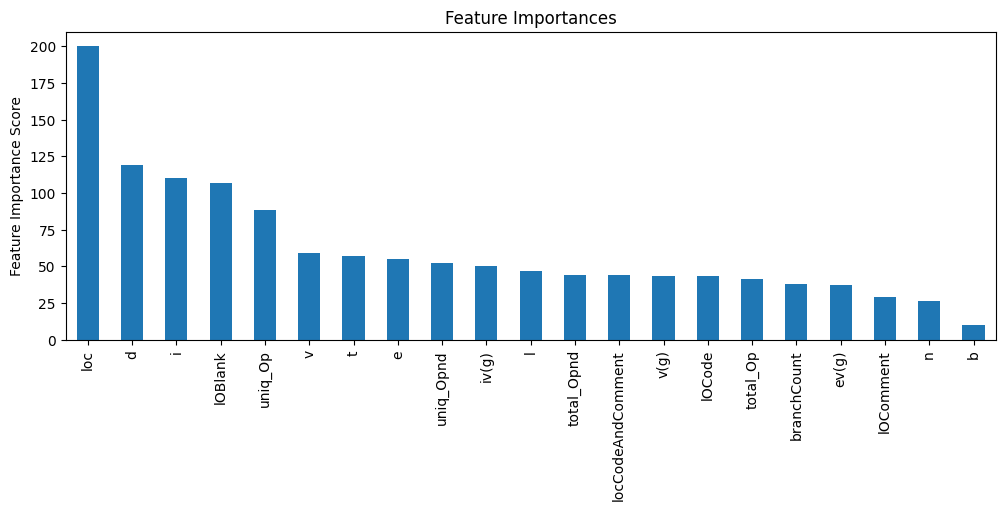

In [47]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=4,
        min_child_weight=4,
        gamma=0,
        subsample=0.6,
        colsample_bytree=0.9,
        objective= 'binary:logistic',
        nthread=4,
        reg_alpha=0.0001,
        scale_pos_weight=1,
        eval_metric='auc',
        seed=27)
modelfit(xgb3, train, predictors)

# Evaluate the best model

Text(0.5, 1.0, 'Confusion Matrix')

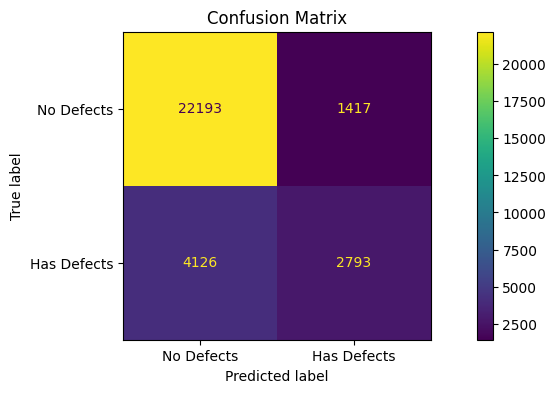

In [54]:
y_pred = xgb3.predict(X_valid)
#make confusion matrix
cm=confusion_matrix(y_valid,y_pred)
ConfusionMatrixDisplay(cm,display_labels=(['No Defects','Has Defects'])).plot()
plt.title('Confusion Matrix')

In [55]:
#print out classification report
print(classification_report(y_valid,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89     23610
           1       0.66      0.40      0.50      6919

    accuracy                           0.82     30529
   macro avg       0.75      0.67      0.70     30529
weighted avg       0.80      0.82      0.80     30529



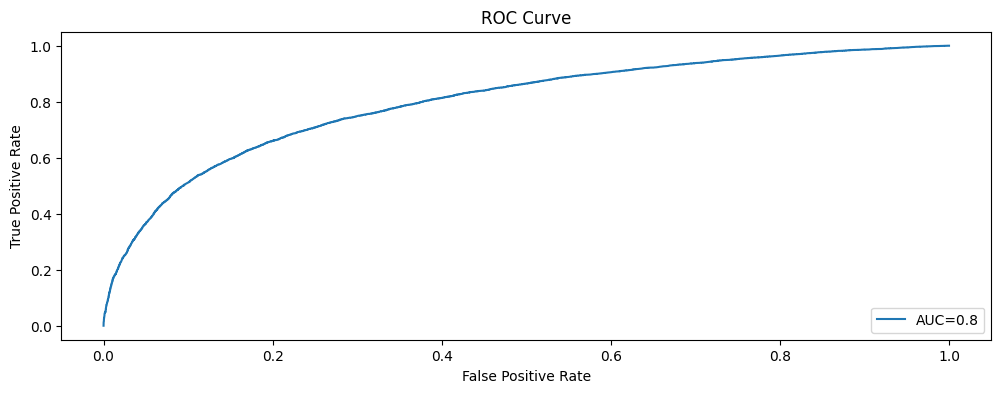

In [57]:
#define metrics
y_pred_proba = xgb3.predict_proba(X_valid)[::,1]
fpr, tpr, _ = roc_curve(y_valid,  y_pred_proba)
auc = round(roc_auc_score(y_valid, y_pred_proba),3)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.title("ROC Curve")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Predicting with test data

In [58]:
test_df = pd.read_csv('/kaggle/input/playground-series-s3e23/test.csv')
test_features = test_df.drop(columns=['id'])
test_predictions = xgb3.predict_proba(test_features)[:,1]

In [59]:
submission = pd.DataFrame({
    'id':test_df['id'],
    'defects':test_predictions
})
#submission

# Saving the submission dataframe to a CSV file
submission.to_csv('submission.csv', index=False)